In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# 문제3. 그래디언트 부스팅 사용
## Concrete.csv 파일 열기

In [3]:
df = pd.read_csv(os.getcwd()+'/3. Big Data 분석_실습화일/Concrete.csv',engine='python',encoding='euc-kr')
df.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## 종속변수와 설명변수 나누기

In [4]:
df_y = df["CONCRETE_COMPRESSIVE_STRENGTH"]
df_x = df.drop("CONCRETE_COMPRESSIVE_STRENGTH", axis=1,inplace = False)

## train, varidation, test 의 표본 0.4, 0.3, 0.3 으로 나누기

In [5]:
df_train_x, df_test_x, df_train_y,df_test_y = train_test_split(df_x,df_y,test_size = 0.3 ,random_state = 1234)
df_train_x, df_validation_x, df_train_y,df_validation_y = train_test_split(df_train_x,df_train_y,test_size = 0.428 ,random_state = 1234)

## 기본 의사결정트리에서의 3개의 표본데이터 설명력 확인

In [6]:
tree_uncustomized = GradientBoostingRegressor(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

#train 설명력 확인
print(tree_uncustomized.score(df_train_x, df_train_y))
#train 설명력 확인
print(tree_uncustomized.score(df_validation_x, df_validation_y))
#test 설명력 확인
print(tree_uncustomized.score(df_test_x, df_test_y))

0.9569177406897725
0.837451601109069
0.873702371206703


## 약한 학습기를 몇개를 생성할지 score점수를 확인하여 선택한다.
100개를 생성 했을때 가장 스코어점수가 높고 격차가 낮기때문에 100을 선택

In [7]:
train_score=[]; validation_score = []
para_n_tree = [n_tree*10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf=GradientBoostingRegressor(n_estimators=v_n_estimators, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    validation_score.append(rf.score(df_validation_x,df_validation_y))


df_score_n=pd.DataFrame()
df_score_n['n_estimator']= para_n_tree
df_score_n['TrainScore']= train_score
df_score_n['TestScore']= validation_score
df_score_n.round(3)

,n_estimator,TrainScore,TestScore
0,10,0.666,0.565
1,20,0.827,0.718
2,30,0.885,0.781
3,40,0.911,0.804
4,50,0.926,0.814
5,60,0.936,0.823
6,70,0.943,0.830
7,80,0.948,0.833
8,90,0.953,0.837
9,100,0.957,0.837


## 그래프로 확인

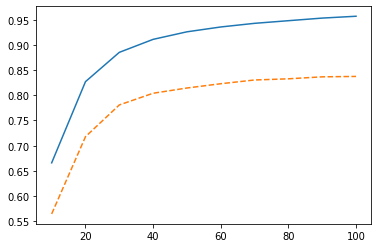

In [8]:
plt.plot(para_n_tree, train_score, linestyle = '-', label = "train score")
plt.plot(para_n_tree, validation_score, linestyle = '--', label = "validation_score")

## 최소 잎의 표본갯수를 선택하는 과정
### 최소 잎의 표본갯수가 5에서 격차가 낮은것을 알 수 있지만 너무 작은 표본이기에 과대적합 위험이 있기 때문에 7을 선택

In [11]:
train_score=[]; validation_score = []
para_leaf = [n_leaf*1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf=GradientBoostingRegressor(n_estimators=100,min_samples_leaf=v_min_samples_leaf, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    validation_score.append(rf.score(df_validation_x,df_validation_y))


df_score_leaf=pd.DataFrame()
df_score_leaf['para_leaf']= para_leaf
df_score_leaf['TrainScore']= train_score
df_score_leaf['validation_score']= validation_score
df_score_leaf.round(3)

,para_leaf,TrainScore,validation_score
0,1,0.957,0.837
1,2,0.956,0.843
2,3,0.956,0.849
3,4,0.957,0.848
4,5,0.957,0.850
5,6,0.953,0.849
6,7,0.952,0.852
7,8,0.952,0.844
8,9,0.950,0.854
9,10,0.950,0.846


## 그래프로 확인

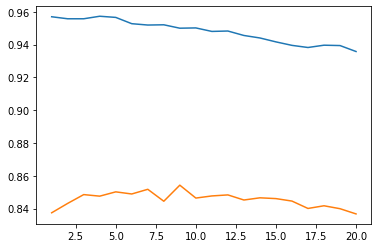

In [12]:
plt.plot(para_leaf, train_score, linestyle = '-', label = "train score")
plt.plot(para_leaf, validation_score, linestyle = '-', label = "validation Score")

## 부모 노드에서 분리되는 노드의 최소 표본 갯수 선택
### split의 갯수가 22일때가 split수가 높으면서 격차가 좁기 때문에 22 선택

In [14]:
train_score=[]; validation_score = []
para_split = [n_split*2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf=GradientBoostingRegressor(n_estimators=100,min_samples_leaf=7,min_samples_split=v_min_samples_split, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    validation_score.append(rf.score(df_validation_x,df_validation_y))


df_score_split=pd.DataFrame()
df_score_split['n_estimator']= para_split
df_score_split['TrainScore']= train_score
df_score_split['validation_score']= validation_score
df_score_split.round(3)

,n_estimator,TrainScore,validation_score
0,4,0.952,0.852
1,6,0.952,0.852
2,8,0.952,0.852
3,10,0.952,0.852
4,12,0.952,0.852
5,14,0.952,0.852
6,16,0.952,0.852
7,18,0.951,0.848
8,20,0.951,0.850
9,22,0.951,0.852


### 그래프로 확인

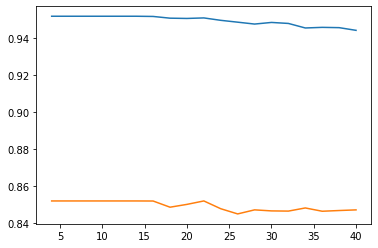

In [15]:
plt.plot(para_split, train_score, linestyle = '-', label = "train score")
plt.plot(para_split, validation_score, linestyle = '-', label = "validation Score")

## 트리의 깊이 설정
깊이가 4 -> 5로 변할때 score점수가 올라 가는 것을 알 수 있기 때문에 깊이는 5로 선택 한다.

In [16]:
train_score=[]; validation_score = []
para_depth = [n_depth for n_depth in range(1,11)]

for v_max_depth in para_depth:
    rf=GradientBoostingRegressor(n_estimators=100,min_samples_leaf=7,min_samples_split=22, max_depth=v_max_depth, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    validation_score.append(rf.score(df_validation_x,df_validation_y))


df_score_depth=pd.DataFrame()
df_score_depth['depth']= para_depth
df_score_depth['TrainScore']= train_score
df_score_depth['validation_score']= validation_score
df_score_depth.round(3)



,depth,TrainScore,validation_score
0,1,0.839,0.755
1,2,0.909,0.833
2,3,0.951,0.852
3,4,0.973,0.847
4,5,0.982,0.854
5,6,0.988,0.854
6,7,0.990,0.846
7,8,0.992,0.851
8,9,0.993,0.856
9,10,0.993,0.856


## 깊이의 그래프 확인

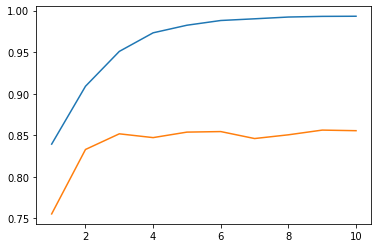

In [17]:
plt.plot(para_depth, train_score, linestyle = '-', label = "train score")
plt.plot(para_depth, validation_score, linestyle = '-', label = "validation Score")

## learning_rate 설정
learning_rate 는 0.5일때 가장 score점수가 높기 때문에 0.5선택

In [19]:
train_score=[]; validation_score = []
para_lr = [lr*0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    rf=GradientBoostingRegressor(n_estimators=100,min_samples_leaf=7,min_samples_split=22, max_depth=5,learning_rate=v_learning_rate, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    validation_score.append(rf.score(df_validation_x,df_validation_y))


df_score_depth=pd.DataFrame()
df_score_depth['learning_rate']= para_lr
df_score_depth['TrainScore']= train_score
df_score_depth['TestScore']= validation_score
df_score_depth.round(3)



,learning_rate,TrainScore,TestScore
0,0.1,0.982,0.854
1,0.2,0.990,0.853
2,0.3,0.994,0.843
3,0.4,0.996,0.846
4,0.5,0.998,0.836
5,0.6,0.998,0.850
6,0.7,0.999,0.828
7,0.8,0.999,0.775
8,0.9,0.999,0.780


### 최종 트리 생성 n=100 , 최소 잎의수 = 7, 최소 분리노드의 표본수 = 22, 최대 깊이 = 5, learnig_rate= 0.5

In [28]:
rf_final = GradientBoostingRegressor(n_estimators=100,min_samples_leaf=7,min_samples_split=22, max_depth=5, learning_rate=0.5,random_state = 1234)
rf_final.fit(df_train_x,df_train_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.5, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=7, min_samples_split=22,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=1234, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## 변수 중요도 확인
### 중요 설명변수 : 나이(AGE), 시멘트(CEMENT),  물(WATER)순으로 영향이 크다고 해석할 수 있음
### 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

              Feature  Importance
7                 AGE       0.337
0              CEMENT       0.330
3               WATER       0.150
1  BLAST_FURNACE_SLAG       0.057
4    SUPERPLASTICIZER       0.049
6      FINE_AGGREGATE       0.032
5    COARSE_AGGREGATE       0.025
2             FLY_ASH       0.021


Text(0, 0.5, '변수')

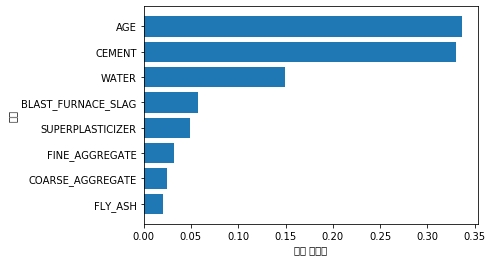

In [23]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
print(df_importance.round(3))


df_importance.sort_values("Importance", ascending =True , inplace= True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")


## test 데이터셋을 이용한 성능 확인
0.8508정도의 성능을 갖는다.

In [29]:
rf_final.score(df_test_x, df_test_y)

0.8508205574570877

## MSE , MSA 값 추출

In [30]:
result = rf_final.predict(df_test_x)

MSE = mean_squared_error(result,df_test_y)
MSA = mean_absolute_error(result, df_test_y)
print("MSE: ",MSE,"MSA: ", MSA)

MSE:  38.868824605825125 MSA:  4.275818486660328


# 결론
### 최종적으로 선택된 그레디언트 부스팅은 30%의 test 데이터로 성능을 확인해 본 결과 0.8508로 높은 수치의 정확도를 얻을 수 있었다.

### 문제2의 랜덤포레스트의 설명력 = 0.8502 MSE:  39.02 MSA:  4.75보다 소폭으로 성능이 향상 된것을 알 수 있었고, 최종으로 그레디언트 부스팅 모델을 선택하여 모델링을 진행 한다.
